## Exemple d'interrogation du point d'accès SPARQL de la Bibliothèque nationale de France (BNF)

Dans cet exemple, après avoir interrogé le point d'accès SPARQL de la BNF, on extrait des données reçues l'année de naissance de la population et on propose différentes distributions permettant de mettre en évitence l'évolution des effectifs des auteurs d'ouvrages conservés à la BNF ayant été actifs dans les disciplines de l'économie et du droit.

On créera également un document CSV exportable et analysable avec d'autres outils (un tableur par ex.).

* Point d'accès SPARQL de la BNF : https://data.bnf.fr/sparql/
* Le projet Data BNF : https://api.bnf.fr/fr/
* L'ontologie de Data BNF : https://data.bnf.fr/en/opendata





### Importer les librairies à utiliser

In [14]:
from SPARQLWrapper import SPARQLWrapper, SPARQLWrapper2, JSON, TURTLE, XML, RDFXML
import pprint
import csv
# from bs4 import BeautifulSoup
import matplotlib.pyplot as plt

from collections import Counter
from operator import itemgetter
import pandas as pd


### Préparation et exécution de la requête SPARQL

In [15]:
query = """
PREFIX  egr:  <http://rdvocab.info/ElementsGr2/>
PREFIX foaf: <http://xmlns.com/foaf/0.1/>
# PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
 
SELECT DISTINCT  ?s ?name ?prefLabel ?annee ?bio ?pb 
WHERE
  { { 
    
    
    { SELECT DISTINCT  ?s ?bio
        WHERE
          {   { ?s egr:biographicalInformation ?bio
                FILTER ( CONTAINS(?bio, "économist") || CONTAINS(?bio, "Economist") || CONTAINS(?bio, "Économist") )
              }
            UNION
              { ?s egr:biographicalInformation ?bio
                FILTER ( CONTAINS(?bio, "jurist") || CONTAINS(?bio, "Juriste") || CONTAINS(?bio, "Droit") || CONTAINS(?bio, "droit") )
              }
          }
      }
      ?s egr:dateOfBirth ?bd

    OPTIONAL {?s egr:placeOfBirth ?pb}
    OPTIONAL {?s foaf:name ?name}
    OPTIONAL {?s skos:prefLabel ?prefLabel}
    }
    BIND(STRBEFORE(STRAFTER(STR(?bd), "http://data.bnf.fr/date/"), "/") AS ?annee)
    FILTER ( ?annee > "1800" )

  }

ORDER BY ?annee
#LIMIT 10
"""

In [16]:
sparql = SPARQLWrapper("https://data.bnf.fr/sparql") ##, returnFormat=RDFXML)

In [17]:
sparql.setQuery(query)
sparql.setReturnFormat(JSON)

In [18]:
rc = sparql.queryAndConvert()
type(rc)

dict

### Analyse du résultat

In [19]:
# Nombre de lignes du résultat
len(rc['results']['bindings'])

8405

In [20]:
# Inspecter les trois premières lignes
i = 0
for l in rc['results']['bindings']:
    if i < 3:
        print(l)
        i += 1

{'s': {'type': 'uri', 'value': 'http://data.bnf.fr/ark:/12148/cb120886836#about'}, 'name': {'type': 'literal', 'value': 'Carlo Cattaneo'}, 'annee': {'type': 'literal', 'value': '1801'}, 'bio': {'type': 'literal', 'value': 'Écrivain, historien et économiste. - Représente le courant fédéraliste du Risorgimento. - Fondateur du périodique scientifique "Il Politecnico" (1839). - Fit partie du gouvernement provisoire de Lombardie en 1848'}, 'pb': {'type': 'literal', 'value': 'Milan, Italie'}}
{'s': {'type': 'uri', 'value': 'http://data.bnf.fr/ark:/12148/cb123560411#about'}, 'name': {'type': 'literal', 'value': 'Constantin Pecqueur'}, 'annee': {'type': 'literal', 'value': '1801'}, 'bio': {'type': 'literal', 'value': "Économiste. - Ancien sous-bibliothécaire à la bibliothèque de l'Assemblée nationale, Paris"}, 'pb': {'type': 'literal', 'value': 'Arlieux (Nord)'}}
{'s': {'type': 'uri', 'value': 'http://data.bnf.fr/ark:/12148/cb118905060#about'}, 'name': {'type': 'literal', 'value': 'Frédéric Ba

In [ ]:
# Extraire les valeurs des cinq premières lignes
# Le test permet de trouver le prefLabel si le name manque
i = 0
result = []
for l in rc['results']['bindings']:
    if i < 10000 : ## 5:
        try: 
            name = l['name']['value']
            result.append([l['s']['value'],name,l['annee']['value'],l['bio']['value']])
        except Exception as e :
            print(e)
            try: 
                name = l['prefLabel']['value']
                result.append([l['s']['value'],name,l['annee']['value'],l['bio']['value']])
            except Exception as e:
                print(e)
                result.append([l['s']['value'],'',l['annee']['value'],l['bio']['value']])

        i += 1

In [22]:
print(len(result))
result[:5]

8405


[['http://data.bnf.fr/ark:/12148/cb120886836#about',
  'Carlo Cattaneo',
  '1801',
  'Écrivain, historien et économiste. - Représente le courant fédéraliste du Risorgimento. - Fondateur du périodique scientifique "Il Politecnico" (1839). - Fit partie du gouvernement provisoire de Lombardie en 1848'],
 ['http://data.bnf.fr/ark:/12148/cb123560411#about',
  'Constantin Pecqueur',
  '1801',
  "Économiste. - Ancien sous-bibliothécaire à la bibliothèque de l'Assemblée nationale, Paris"],
 ['http://data.bnf.fr/ark:/12148/cb118905060#about',
  'Frédéric Bastiat',
  '1801',
  'Économiste. - Député de Bayonne (1848-1850)'],
 ['http://data.bnf.fr/ark:/12148/cb11897951m#about',
  'Antoine-Augustin Cournot',
  '1801',
  "Mathématicien. - Philosophe. - Économiste. - Recteur de l'académie de Lyon"],
 ['http://data.bnf.fr/ark:/12148/cb12815310c#about',
  'John-Théodore Dupont-White',
  '1801',
  "Avocat à Paris (1822-1830) puis procureur du roi à Montdidier, Senlis puis Beauvais. - Membre de la Sociét

### Sauvegarder le résultat sous forme de document CSV
Documentation: https://docs.python.org/3/library/csv.html

In [23]:
with open('sparql_bnf_1.csv', 'w', newline='') as csvfile:
    document = csv.writer(csvfile, delimiter='|',
                            quotechar='"', quoting=csv.QUOTE_MINIMAL)
    for l in rc['results']['bindings']:
        try: 
            name = l['name']['value']
            document.writerow([l['s']['value'],name,l['annee']['value'],l['bio']['value']])
        except :
            try: 
                name = l['prefLabel']['value']
                document.writerow([l['s']['value'],name,l['annee']['value'],l['bio']['value']])
            except :
                document.writerow([l['s']['value'],'',l['annee']['value'],l['bio']['value']])


In [24]:
df_result = pd.DataFrame(result)
df_result.head()

,0,1,2,3
0,http://data.bnf.fr/ark:/12148/cb120886836#about,Carlo Cattaneo,1801,"Écrivain, historien et économiste. - Représent..."
1,http://data.bnf.fr/ark:/12148/cb123560411#about,Constantin Pecqueur,1801,Économiste. - Ancien sous-bibliothécaire à la ...
2,http://data.bnf.fr/ark:/12148/cb118905060#about,Frédéric Bastiat,1801,Économiste. - Député de Bayonne (1848-1850)
3,http://data.bnf.fr/ark:/12148/cb11897951m#about,Antoine-Augustin Cournot,1801,Mathématicien. - Philosophe. - Économiste. - R...
4,http://data.bnf.fr/ark:/12148/cb12815310c#about,John-Théodore Dupont-White,1801,Avocat à Paris (1822-1830) puis procureur du r...


In [25]:
print(list(df_result.columns))
df_result.columns = ['uri', 'name', 'annee_naiss', 'biogr']
print(list(df_result.columns))

[0, 1, 2, 3]
['uri', 'name', 'annee_naiss', 'biogr']


In [26]:
with open('spreadsheets/sparql_bnf_1.csv', 'w', newline='') as csvfile:
    df_result.to_csv(csvfile, sep='|')

In [27]:
df_result['annee_naiss']

0       1801
1       1801
2       1801
3       1801
4       1801
        ... 
8400    1976
8401    1977
8402    1979
8403    1980
8404    1988
Name: annee_naiss, Length: 8405, dtype: object

In [28]:
df_result['annee_naiss']

0       1801
1       1801
2       1801
3       1801
4       1801
        ... 
8400    1976
8401    1977
8402    1979
8403    1980
8404    1988
Name: annee_naiss, Length: 8405, dtype: object

### Inspecter les années de naissance et compter le nombre de naissances par années

In [29]:
# Explore
listeAnnees = []
for l in rc['results']['bindings']:
    listeAnnees.append(l['annee']['value'])

In [31]:
listeAnnees[51:58]

['1803', '1803', '1803', '1803', '1803', '1803', '1803']

In [32]:
min(listeAnnees), max(listeAnnees)

('1801', '1988')

In [33]:
listeAnnees.sort()

In [34]:
listeAnnees[2]

'1801'

In [35]:
# Compter les naissances par année
counterListeAnnees = Counter(listeAnnees)
groupedListeAnnees = list(zip(counterListeAnnees.keys(), counterListeAnnees.values()))

In [36]:
groupedListeAnnees[:5]

[('1801', 22), ('1802', 23), ('1803', 25), ('1804', 23), ('1805', 22)]

In [37]:
# Transformer les années de chaines de caractères à chiffres
groupedListeAnnees = [[int(i[0]), i[1]] for i in groupedListeAnnees]
groupedListeAnnees[:5]

[[1801, 22], [1802, 23], [1803, 25], [1804, 23], [1805, 22]]

In [38]:
### Créer la liste des périodes de 20 ans, i.e. la liste de la première année de chaque période
d_list = []
period = 20
d_start = 1801
i = 0
d_list = []
d_list.append(d_start)

while i < 10:
    d_start = d_start + period
    d_list.append(d_start)
    i += 1

In [39]:
print(d_list[:2])
min(d_list), max(d_list)

[1801, 1821]


(1801, 2001)

### Distribution des naissances par année et par période de 20 ans

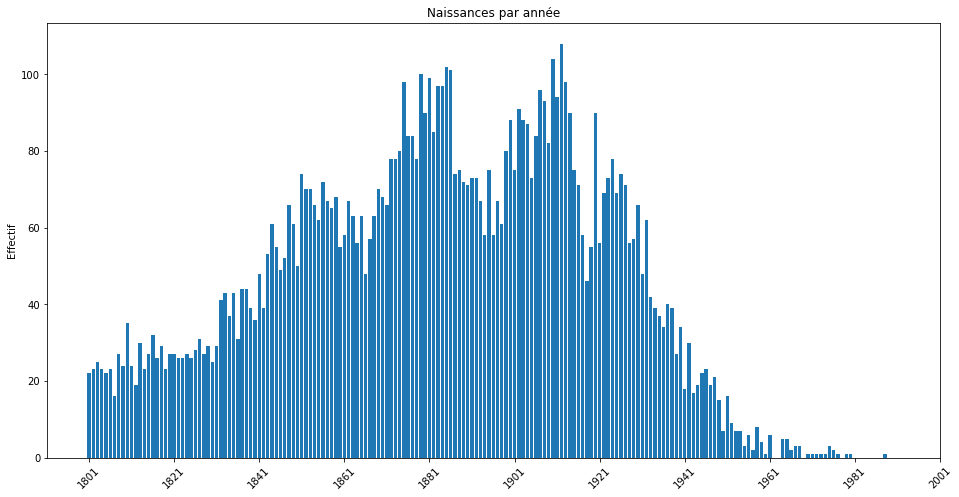

In [40]:
# Distribution par année

objects = [l[0] for l in groupedListeAnnees]
eff = [l[1] for l in groupedListeAnnees]

p1 = plt.bar(objects, eff)

plt.xticks(d_list)
plt.ylabel('Effectif')
plt.title('Naissances par année')
plt.gcf().set_size_inches(16, 8)
#plt.gca().axes.get_xaxis().set_visible(False)
# supported formats: eps, pdf, pgf, png, ps, raw, rgba, svg, svgz
#plt.savefig('exported_pictures/effectifs_naissances_par_annee.png', dpi=100, bbox_inches = "tight") #pdf, svg
plt.xticks(rotation=45)
plt.show()


In [41]:
# Regroupement par période de 20 ans
i_list = []
for i in d_list:
    i_n = 0
    for l in groupedListeAnnees:
        if l[0] >= i and l[0] < (i + 20):
            i_n = i_n + l[1]
    i_list.append([i, i_n])        

In [42]:
i_list[30:35]

[]

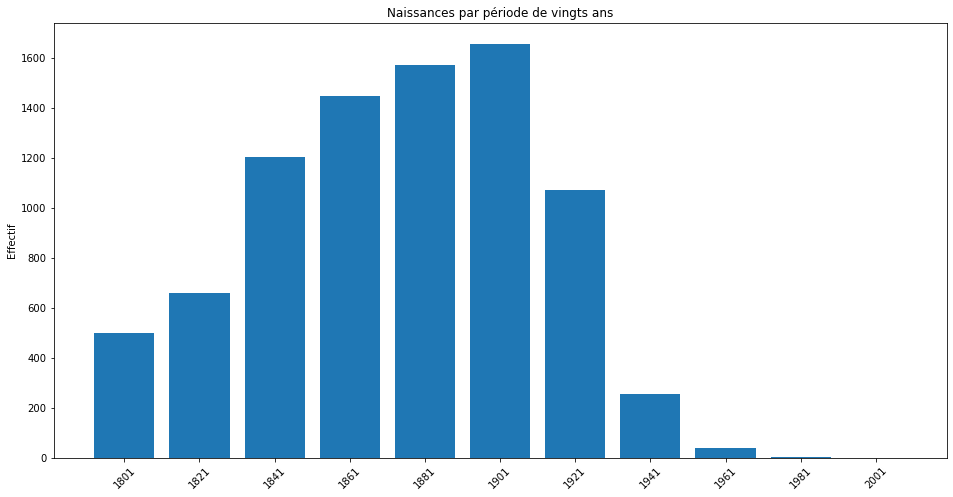

In [43]:
# Distribution par période de 20 ans

objects = [str(l[0]) for l in i_list]
eff = [l[1] for l in i_list]

p1 = plt.bar(objects, eff)

plt.ylabel('Effectif')
plt.title('Naissances par période de vingts ans')
plt.gcf().set_size_inches(16, 8)
# supported formats: eps, pdf, pgf, png, ps, raw, rgba, svg, svgz
# plt.savefig('exported_pictures/effectifs_annees_reference_par_periode.png', dpi=100, bbox_inches = "tight") #pdf, svg
plt.xticks(rotation=45)
plt.show()


In [44]:
df_result['biogr'][:3]

0    Écrivain, historien et économiste. - Représent...
1    Économiste. - Ancien sous-bibliothécaire à la ...
2          Économiste. - Député de Bayonne (1848-1850)
Name: biogr, dtype: object

In [46]:
for l in [tok for tok in [l.split(" ") for l in df_result['biogr'][:3]] ]:
    for tok in l:
        if len(tok) > 3:
            print(tok)

Écrivain,
historien
économiste.
Représente
courant
fédéraliste
Risorgimento.
Fondateur
périodique
scientifique
Politecnico"
(1839).
partie
gouvernement
provisoire
Lombardie
1848
Économiste.
Ancien
sous-bibliothécaire
bibliothèque
l'Assemblée
nationale,
Paris
Économiste.
Député
Bayonne
(1848-1850)
